In [1]:
import pandas as pd
import numpy as np
import re
import string

# data = pd.read_csv("/kaggle/input/entity-annotated-corpus/ner_dataset.csv", encoding="latin1")

data = pd.read_csv("/kaggle/input/nlp-t3/train.csv")
test_data = pd.read_csv("/kaggle/input/nlp-ner/test.csv")

In [2]:
data['Tag'].value_counts()
print("test")
test_data['Tag'].value_counts()



test


O                 27857
I_PRECEDENT        1793
I_PROVISION         439
I_STATUTE           383
I_CASE_NUMBER       344
I_COURT             326
I_ORG               310
B_OTHER_PERSON      276
B_PROVISION         258
B_DATE              222
B_STATUTE           222
I_OTHER_PERSON      195
B_GPE               183
B_COURT             178
B_PRECEDENT         177
B_ORG               159
B_CASE_NUMBER       121
I_DATE              102
B_WITNESS            58
I_WITNESS            54
I_GPE                47
I_PETITIONER         11
I_RESPONDENT          9
B_PETITIONER          9
B_JUDGE               8
I_JUDGE               7
B_RESPONDENT          5
Name: Tag, dtype: int64

In [3]:
data.head(1)

,Sentence #,Word,Tag
0,1,"Therefore,",O


In [25]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
          
getter = SentenceGetter(data)
sentences = getter.sentences

test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences
print(len(test_sentences),len(sentences))

949 8019


In [5]:
print(sentences[1:3])

[[('The', 'O'), ('petitioner', 'O'), ('in', 'O'), ('W.P.No.15821', 'B_CASE_NUMBER'), ('of', 'I_CASE_NUMBER'), ('2008', 'I_CASE_NUMBER'), ('was', 'O'), ('never', 'O'), ('considered', 'O'), ('for', 'O'), ('appointment', 'O'), ('under', 'O'), ('the', 'O'), ('National', 'B_ORG'), ('Rural', 'I_ORG'), ('Employment', 'I_ORG'), ('Guarantee', 'I_ORG'), ('Scheme', 'I_ORG'), ('either', 'O'), ('through', 'O'), ('Employment', 'O'), ('Exchange', 'O'), ('sponsorship', 'O'), ('or', 'O'), ('by', 'O'), ('Outsourcing', 'O'), ('Agencies.', 'O')], [('The', 'O'), ('factum', 'O'), ('of', 'O'), ('accident,', 'O'), ('allegation', 'O'), ('of', 'O'), ('rash', 'O'), ('and', 'O'), ('negligent', 'O'), ('driving', 'O'), ('causing', 'O'), ('death', 'O'), ('of', 'O'), ('Sukendra', 'B_OTHER_PERSON'), ('Pal', 'I_OTHER_PERSON'), ('Singh', 'I_OTHER_PERSON'), ('were', 'O'), ('denied.', 'O')]]


In [6]:
from math import nan
# temp_data = data+test_data
words = list(set(data["Word"].values))
test_words = list(set(test_data['Word'].values))
words = set(words+test_words)
n_words = len(words)

tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)




## Prepare the data
Now we introduce dictionaries of words and tags.

In [7]:
from future.utils import iteritems


word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i:w for w, i in word2idx.items()}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}


In [8]:
if "Amendment;" in test_words:
    print("yes")
if "Amendment;" in words:
    print("yes")
print(word2idx['Amendment;'])

yes
yes
28192


In [37]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

maxlen = max([len(s) for s in sentences])

X = [[word2idx[w[0]] for w in s] for s in sentences]
X_train = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
y_train = [to_categorical(i, num_classes=n_tags) for i in y]
X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
print(len(X_test))
X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=n_words - 1) 

y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]
print(len(y_test))
y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])
y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]
print(len(y_test))
# Split train and test data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# X_train = data['Word']
# y_train = data['Tag']

# X_test = test_data['Word']
# y_test = test_data['Tag']

print(len(X_test),len(X_train))

949
949
949
949 8019


## Setup the CRF-BILSTM



In [10]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-v4cmk1m2
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-v4cmk1m2
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=f5c30a98459b6d732b9cde084426ee96a5507b2473bd3086f8697c4ab47d0a4e
  Stored in directory: /tmp/pip-ephem-wheel-cache-5byqplra/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [29]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF

In [30]:
print(k.__version__)

2.3.1


## WORD2VEC


In [13]:
# from gensim.models import KeyedVectors
# from tqdm import tqdm
# input = Input(shape=(76,))
# word_embedding_size = 150
# embedding_dim = 300
# print("here")
# word2vec_path = "/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin"  # Replace this with the path to your Word2Vec model

# def load_word2vec_embeddings(word2vec_path, embedding_dim, word_index):
#     word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
#     print("loading done")
#     embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
#     for word, i in tqdm(word_index.items()):
#         if word in word2vec_model:
#             embedding_matrix[i] = word2vec_model[word]

#     return embedding_matrix

# embedding_matrix = load_word2vec_embeddings(word2vec_path, embedding_dim, word2idx)

## GLOVE

In [14]:
input = Input(shape=(1,))
word_embedding_size = 150

embedding_path = '/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'
embedding_dim = 100
def load_glove_embeddings(embedding_path, embedding_dim, word_index):
    embeddings_index = {}
    with open(embedding_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = load_glove_embeddings(embedding_path, embedding_dim, word2idx)





In [15]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF
m = 76
input = Input(shape=(m,))
word_embedding_size = 100

# Embedding Layer
model = Embedding(input_dim=n_words+1, output_dim=word_embedding_size,weights=[embedding_matrix],  input_length=m)(input)

# BI-LSTM Layer
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)

# TimeDistributed Layer
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  

# CRF Layer
crf = CRF(n_tags)

out = crf(model)  # output
model = Model(input, out)

In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 76)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 76, 100)           3452700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 76, 200)           160800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 76, 200)           320800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 76, 27)            5427      
_________________________________________________________________
crf_1 (CRF)                  (None, 76, 27)            1539      
Total params: 3,941,266
Trainable params: 3,941,266
Non-trainable params: 0
_________________________________________________

In [41]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

#Optimiser 
adam = k.optimizers.Adam(lr=0.05, beta_1=0.2, beta_2=0.2)

# Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])

# model.summary()

# Saving the best model only
filepath="ner-bi-lstm-td-model-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the best model
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=20, validation_split=0.1, verbose=1, callbacks=callbacks_list)

/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '
/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7217 samples, validate on 802 samples
Epoch 1/20
7217/7217 [==============================] - 12s 2ms/step - loss: -0.0666 - crf_viterbi_accuracy: 0.9750 - accuracy: 6.1624e-04 - val_loss: -0.0467 - val_crf_viterbi_accuracy: 0.9668 - val_accuracy: 0.9666

Epoch 00001: val_accuracy improved from -inf to 0.96656, saving model to ner-bi-lstm-td-model-0.97.hdf5
Epoch 2/20
7217/7217 [==============================] - 9s 1ms/step - loss: -0.0879 - crf_viterbi_accuracy: 0.9770 - accuracy: 6.1624e-04 - val_loss: -0.0521 - val_crf_viterbi_accuracy: 0.9654 - val_accuracy: 0.9646

Epoch 00002: val_accuracy did not improve from 0.96656
Epoch 3/20
7217/7217 [==============================] - 9s 1ms/step - loss: -0.1072 - crf_viterbi_accuracy: 0.9750 - accuracy: 6.1624e-04 - val_loss: -0.0814 - val_crf_viterbi_accuracy: 0.9664 - val_accuracy: 0.9654

Epoch 00003: val_accuracy did not improve from 0.96656
Epoch 4/20
7217/7217 [==============================] - 9s 1ms/step - loss: -0.1291 - c

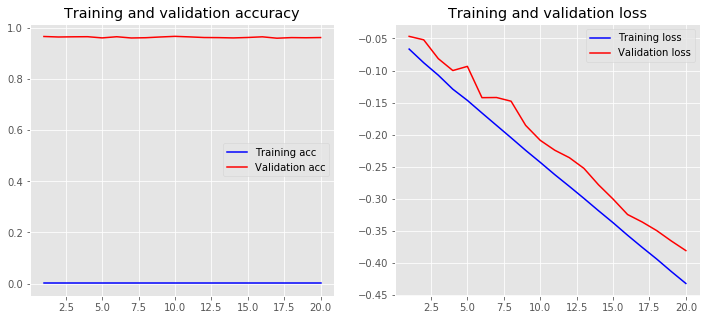

In [42]:
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [43]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
print(len(X_test))
test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

949
949/949 [==============================] - 2s 2ms/step


In [20]:
# ! pip install seqeval


In [44]:
def F1_Score(y_test,y_pred):
    tp = {}
    fp = {}
    fn = {}

    classes = []
    for i in y_test:
        if i not in classes:
            classes.append(i)   
    for i in y_pred:
        if i not in classes:
            classes.append(i)
    for i in classes:
#         print(i)
        tp[i] = 0
        fp[i] = 0
        fn[i] = 0
    print(len(y_test),len(y_pred))
    for i in range(len(y_test)):
        if y_test[i] == y_pred[i]:
            tp[y_test[i]] += 1
        else:
            fp[y_pred[i]] += 1
            fn[y_test[i]] += 1
    precision = {}
    recall = {}
    f = {}
    for i in classes:
#         print(i)
        if tp[i] == 0:
            precision[i] = 0
            recall[i] = 0
            f[i] = 0
        else:
            precision[i] = tp[i]/(tp[i]+fp[i])
            recall[i] = tp[i]/(tp[i]+fn[i])
            f[i] = 2*precision[i]*recall[i]/(precision[i]+recall[i])
    return f,precision,recall

# Example usage:
# # y_true and y_pred are lists containing true labels and predicted labels, respectively
# y_true = [0, 1, 2, 1, 2]
# y_pred = [0, 1, 1, 1, 2]

y_true = []
y_pred = []
for i in test_labels:
    for j in i:
        y_true.append(j)
for i in pred_labels:
    for j in i:
        y_pred.append(j)
# print(y_true)
precision, recall, f1_score = F1_Score(y_true, y_pred)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1_score)
for i in f1_score:
    print("F1 score for class ",i," is ",f1_score[i]," with precision ",precision[i]," and recall ",recall[i])
    
def avg_f1(f1):
    return sum(f1_score.values())/len(f1_score)
print("Average F1 score is ",avg_f1(f1_score))


72124 72124
F1 score for class  O  is  0.975825934649997  with precision  0.9846273386556159  and recall  0.9935889551688089
F1 score for class  B_STATUTE  is  0.8603603603603603  with precision  0.8268398268398268  and recall  0.7958333333333333
F1 score for class  B_PRECEDENT  is  0.7627118644067796  with precision  0.7500000000000001  and recall  0.7377049180327869
F1 score for class  I_PRECEDENT  is  0.8650306748466258  with precision  0.8888252148997136  and recall  0.9139658220388922
F1 score for class  B_JUDGE  is  0.125  with precision  0.05128205128205128  and recall  0.03225806451612903
F1 score for class  I_JUDGE  is  0.14285714285714285  with precision  0.05405405405405406  and recall  0.03333333333333333
F1 score for class  B_COURT  is  0.8202247191011236  with precision  0.8588235294117647  and recall  0.9012345679012346
F1 score for class  I_COURT  is  0.7852760736196319  with precision  0.8152866242038216  and recall  0.847682119205298
F1 score for class  I_STATUTE  is 

In [40]:
! pip install sklearn_crfsuite
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

                precision    recall  f1-score   support

 B_CASE_NUMBER       0.60      0.50      0.55       121
       B_COURT       0.85      0.84      0.84       178
        B_DATE       0.46      0.90      0.61       222
         B_GPE       0.48      0.21      0.30       183
       B_JUDGE       0.00      0.00      0.00         8
         B_ORG       0.32      0.35      0.33       159
B_OTHER_PERSON       0.29      0.75      0.42       276
  B_PETITIONER       0.00      0.00      0.00         9
   B_PRECEDENT       0.78      0.63      0.69       177
   B_PROVISION       0.94      0.88      0.91       258
  B_RESPONDENT       0.00      0.00      0.00         5
     B_STATUTE       0.86      0.90      0.88       222
     B_WITNESS       0.14      0.03      0.06        58
 I_CASE_NUMBER       0.64      0.76      0.69       344
       I_COURT       0.69      0.83      0.76       326
        I_DATE       0.46      0.89      0.61       102
         I_GPE       0.00      0.00      0.00  